In [1]:
from __future__ import print_function
from fenics import *
from mshr import *
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

parameters['allow_extrapolation'] = True
WARNING = 30
set_log_level(WARNING)

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

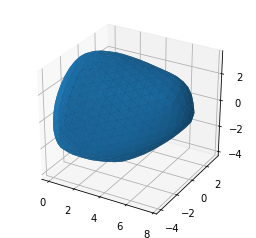

In [2]:
# Importing the mesh
mesh=Mesh()

f = XDMFFile(mesh.mpi_comm(),"Files/pressure_mesh.xdmf")
f.read(mesh)
f.close()

plot(mesh)

In [3]:
# Importing initial pressure

path = "Files/coronary_pressure.csv"

df = pd.read_csv(path,names=['time','pressure'])

In [4]:
time = np.array(df['time'])
pressure = np.array(df['pressure']) # mmHg, 0.133322368 mmHg = 1 Kpa
pressure = pressure * 0.133322368 # KPa

In [5]:
num_time_steps = 100
new_time = np.linspace(0,1,num_time_steps)
func_interpol_p = interp1d(time,pressure)

new_pressure = func_interpol_p(new_time)

time = new_time
pressure = new_pressure

Text(0.5,1,'Initial pressure')

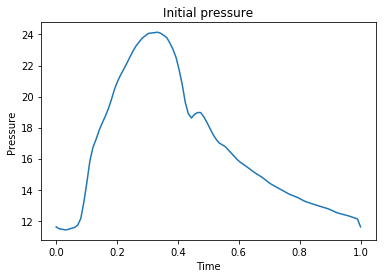

In [6]:
plt.plot(time,pressure)
plt.xlabel('Time')
plt.ylabel('Pressure')
plt.title('Initial pressure')

In [68]:
# Define function spaces. Define trial and test functions

el = tetrahedron

P = FiniteElement('P',el,2)


element = MixedElement([P,P,P])
FS = FunctionSpace(mesh,element)


# Define test functions
q1,q2,q3 = TestFunctions(FS)
v1, v2, v3 = TestFunctions(FS)


K1 = Constant(1) #(mm^2)/(kPa*s)
K2 = Constant(10) #(mm^2)/kPa*s
K3 = Constant(20) #(mm^2)/kPa*s
K = Constant((K1,K2,K3))

Kr = 10 # Reaction rate

dt = Constant(0.01)
diff_o2 = 0.9*10**-9
D = Constant(diff_o2)

beta12 = Constant(0.02) #1/(kPa*s)
beta23 = Constant(0.05) #1/(kPa*s)

p = Function(FS)
v_d = Function(FS)
c = Function(FS)
c_n = Function(FS)

p1, p2, p3 = split(p)
v_d1, v_d2, v_d3 = split(v_d)
c1, c2, c3 = split(c)
c1_n, c2_n, c3_n = split(c_n)

#k = Constant(dt)
S3 = - Constant(0.1)*(p3-Constant(3.0)) #Sink term in the third apartment
F = -K1 * dot(grad(p1), grad(q1))*dx + -K2 * dot(grad(p2), grad(q2))*dx + -K3 * dot(grad(p3), grad(q3))*dx  + dot(beta12*(p1-p2),q1)*dx + dot(beta12*(p2-p1),q2)*dx + dot(beta23*(p2-p3),q2)*dx + dot(beta23*(p3-p2),q3)*dx - dot(S3,q3)*dx
F2 = ((c1 - c1_n) / dt)*v1*dx + dot(v_d1, div(c1))*v1*dx - D*dot(grad(c1), grad(v1))*dx


markers = MeshFunction("size_t",mesh,"Files/pressure_markers.xml")

In [87]:
pD = Expression("p",p=0.0,degree=2)
bc = DirichletBC(FS.sub(0),pD,markers,1)
bcs = [bc]



TOL = 1e-8

c1_n = Constant(0.1)
# Time loop
for t,i_p in zip(time,pressure):
    print(t)
    
    # Update the initial pressure
    pD.p = i_p
    
    # Solve for pressure
    solve(F==0, p, bc)
    p1,p2,p3 = p.split()
    
    # Calculate the velocity
    v_d_ = project(dot(-K,grad(p)))
    v_d.assign(v_d_)
    
    _v_d1, _v_d2, _v_d3 = v_d_.split()

    
    # Solve for concentration
    solve(F2==0,c)
    
    # Update previous solution
    c_n.assign(c)

    
    
    # Save all parameters
#    c_n.assign(c)
#    solve(F2==0, c1)
#    solve(F3==0, c2)
#    solve(F4==0, c3)
#    xdmffile_p1.write(p1,t)
#    xdmffile_p2.write(p2,t)
#    xdmffile_p3.write(p3,t)
#    c_n1.assign(c1)
#    c_n2.assign(c2)
#    c_n3.assign(c3)


#xdmffile_p1.close()
#xdmffile_p2.close()
#xdmffile_p3.close()

0.0
0.010101010101010102
0.020202020202020204
0.030303030303030304
0.04040404040404041
0.05050505050505051
0.06060606060606061
0.07070707070707072
0.08080808080808081
0.09090909090909091
0.10101010101010102
0.11111111111111112
0.12121212121212122
0.13131313131313133
0.14141414141414144
0.15151515151515152
0.16161616161616163
0.17171717171717174
0.18181818181818182
0.19191919191919193
0.20202020202020204
0.21212121212121213
0.22222222222222224
0.23232323232323235
0.24242424242424243
0.25252525252525254
0.26262626262626265
0.27272727272727276
0.2828282828282829
0.29292929292929293
0.30303030303030304
0.31313131313131315
0.32323232323232326
0.33333333333333337
0.3434343434343435
0.3535353535353536
0.36363636363636365
0.37373737373737376
0.38383838383838387
0.393939393939394
0.4040404040404041
0.4141414141414142
0.42424242424242425
0.43434343434343436
0.4444444444444445
0.4545454545454546
0.4646464646464647
0.4747474747474748
0.48484848484848486
0.494949494949495
0.5050505050505051
0.51515

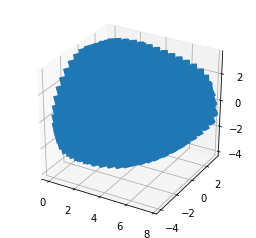

In [89]:
plot(p)

In [91]:
plot(v)

NameError: name 'v' is not defined